In [144]:
import torch
from spp.models.spp_tcn import SPPEstimator
from pathlib import Path
import torchaudio as ta
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [145]:
# Specify the path to the checkpoint and the .wav file
fs = 16000  # 8000 or 16000

if fs == 8000:
    checkpoint_path = Path('/home/marvint/dr/code/deep_learning_projects/spp_paul/spp/saved/20240207_174011_quizzical-flower-12/epoch=35-step=324000.ckpt')
elif fs == 16000:
    checkpoint_path = Path('/home/marvint/dr/code/deep_learning_projects/spp_paul/spp/saved/20240207_174011_crooked-professor-42/epoch=48-step=441000.ckpt')
else:
    raise ValueError('no model trained for this fs...')

# wav_file_path = Path('test.wav')
wav_file_path = Path('realrec_english_wer_Headphones_HeavyBreathing_A317RA15E0SZ4P_113.wav')

model = SPPEstimator
model = model.load_from_checkpoint(checkpoint_path, map_location=device)
model.eval()  # handles batch normalization differently

wav_data, fs_wav = ta.load(wav_file_path)
wav_data = wav_data.to(device=device)
if fs_wav != fs:
    wav_data = ta.functional.resample(wav_data, orig_freq=fs_wav, new_freq=fs)

wav_data = 0.1 * wav_data / wav_data.pow(2).mean().sqrt()
wav_data = wav_data.unsqueeze(0)
display(wav_data.shape)
inp = {
    "input": wav_data,
}

receptive field: 253 time steps


torch.Size([1, 1, 176960])

In [146]:
# play sound
display(Audio(wav_data[0].cpu().numpy(), rate=fs))

In [147]:
with torch.no_grad():  # no gradients needed for inference
    output = model(inp)
spp_estimate = output["spp_estimate"].squeeze(0)

# get noisy periodogram for plotting
noisy_periodogram = model.stft.get_stft(wav_data).abs().pow(2).cpu().numpy().squeeze(0).squeeze(0)


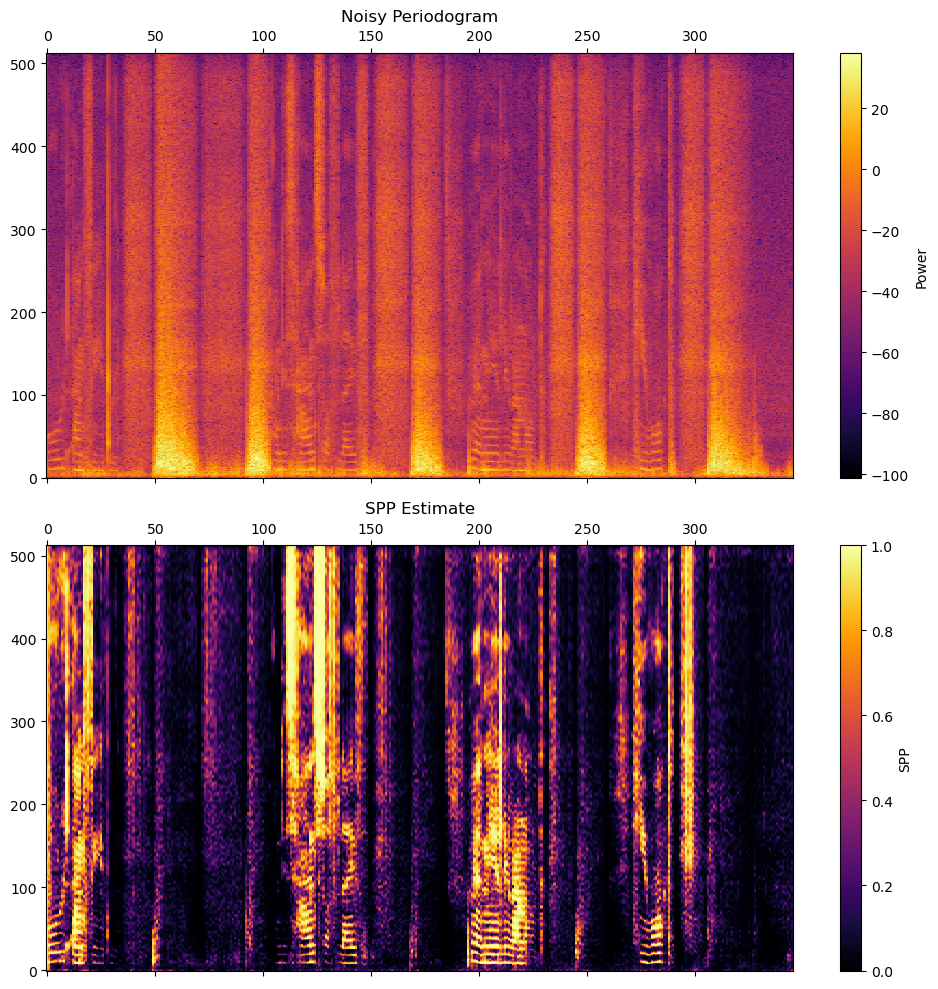

In [148]:
# plot noisy periodogram and spp estimate using matshow in two subplots below each other
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
im1 = ax[0].matshow(10 * np.log10(noisy_periodogram), origin='lower', aspect='auto', cmap='inferno')
ax[0].set_title('Noisy Periodogram')
im2 = ax[1].matshow(spp_estimate.cpu().numpy(), origin='lower', aspect='auto', vmin=0, vmax=1, cmap='inferno')
ax[1].set_title('SPP Estimate')
cbar1 = fig.colorbar(im1, ax=ax[0])
cbar1.set_label('Power')
cbar2 = fig.colorbar(im2, ax=ax[1])
cbar2.set_label('SPP')
plt.tight_layout()
fig.show()

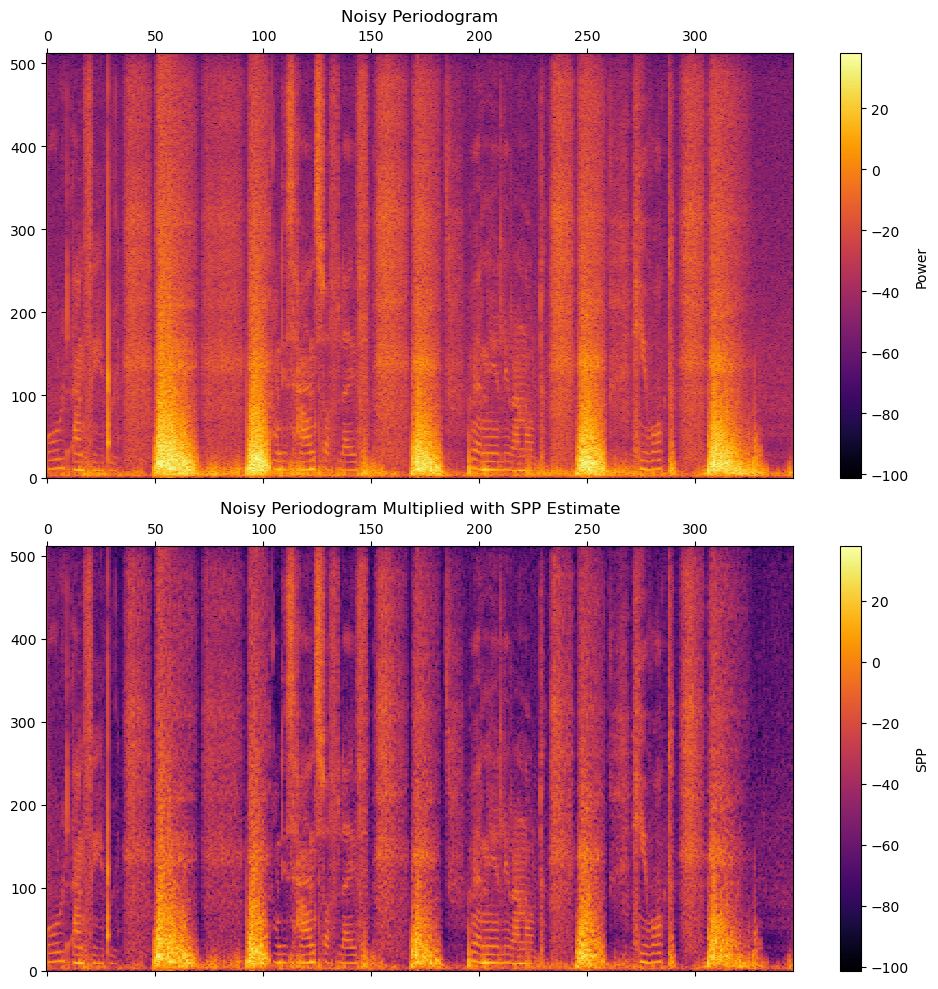

In [149]:
# plot noisy spectrogram simply multiplied with SPP estimate
vmin, vmax = 10 * np.log10(noisy_periodogram).min(), 10 * np.log10(noisy_periodogram).max()
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

im1 = ax[0].matshow(10 * np.log10(noisy_periodogram), origin='lower', aspect='auto', cmap='inferno')
ax[0].set_title('Noisy Periodogram')
im2 = ax[1].matshow(10 * np.log10(spp_estimate.cpu().numpy() * noisy_periodogram), origin='lower', aspect='auto', cmap='inferno', vmin=vmin, vmax=vmax)
ax[1].set_title('Noisy Periodogram Multiplied with SPP Estimate')
cbar1 = fig.colorbar(im1, ax=ax[0])
cbar1.set_label('Power')
cbar2 = fig.colorbar(im2, ax=ax[1])
cbar2.set_label('SPP')
plt.tight_layout()
fig.show()